Packages

In [15]:
from os import listdir
import matplotlib.pyplot as plt
from imutils import paths
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Data preparation

In [2]:
# Look at data folder structure
classes_dir = listdir("data/Kather_texture_2016_image_tiles_5000")
classes_dir

['.DS_Store',
 '01_TUMOR',
 '02_STROMA',
 '03_COMPLEX',
 '04_LYMPHO',
 '05_DEBRIS',
 '06_MUCOSA',
 '07_ADIPOSE',
 '08_EMPTY']

In [3]:
# Load data
print("[INFO] loading images...")
imagePaths = list(paths.list_images("data/Kather_texture_2016_image_tiles_5000"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = (imagePath.split(os.path.sep)[-2][1])
    # Since we are going to use MobileNetV2 we need to resize the images
    # to the expected size by the pre-trained network.
    image = load_img(imagePath, target_size=(28, 28)) # Resize image
    image = img_to_array(image)
    image = preprocess_input(image)
    image = tf.cast(image, tf.float32) / 255.0 #normalize
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


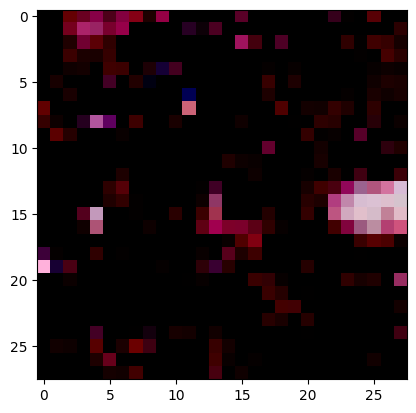

In [4]:
# display resized image
plt.imshow(data[0]*255)

In [5]:
# # perform one-hot encoding on the labels
# lb = LabelBinarizer()
# labels = lb.fit_transform(labels)
# # labels = to_categorical(labels)
# print(labels[0], labels[0][0], type(labels[0]))

In [6]:
# Split into train, val, test set
# x, x_test, y, y_test = train_test_split(data, labels, test_size=0.2,train_size=0.8)
# x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25,train_size =0.75)

VAE encoder network

In [41]:
# Dimensionality of the latent space: a 3D space
latent_dim = 3
encoder_inputs = keras.Input(shape=(28, 28, 3)) # 1 for grayscale
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs) #working with strides and not max pooling
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
# The input image ends up being encoded into these
# two parameters (parameters are being predicted by model!)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [28]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 32)   896         ['input_4[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_4[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_5[0][0]']               
                                                                                            

In [29]:
class Sampler(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        # Draw a batch of random normal
        # Apply the VAE vectors.
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        # Apply the VAE vectors sampling formula
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [42]:
# Input where we’ll feed z
latent_inputs = keras.Input(shape=(latent_dim,))
# Produce the same number of coefficients that we
# had at the level of the Flatten layer in the encoder
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# Revert the Flatten layer of the encoder
x = layers.Reshape((7, 7, 64))(x)
# Revert the Conv2D layers of the encoder
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# The output ends up with shape (28, 28, 3)
decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [43]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_10 (Dense)            (None, 3136)              12544     
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 28, 28, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 3)         867 

In [32]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        # We use these metrics to keep track of the loss averages
        # over each epoch.
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
        name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        # We list the metrics in the metrics
        # property to enable the model to reset
        # them after each epoch (or between
        # multiple calls to fit()/evaluate())

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            # We sum the reconstruction loss over the spatial
            # dimensions (axes 1, 2) and take its mean over the
            # batch dimension.
            reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2))
            )
            # Add the regularization term (Kullback–Leibler divergence)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss) #complicated part,math in slides
        self.kl_loss_tracker.update_state(kl_loss) #complicated part,math in slides
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Training the VAE

In [16]:
# Split into train, val, test set
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,train_size=0.8)
# Train on all train / test images without labels
all_images = np.concatenate([x_train, x_test], axis=0)

In [46]:
# Vae
vae = VAE(encoder, decoder)
# Note that we don’t pass a loss argument in compile(), since the loss
# is already part of the train_step().
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
# Note that we don’t pass targets in fit(), since train_step()
# doesn’t expect any
vae.fit(all_images, epochs=30, batch_size=128)

Epoch 1/30
40/40 [==============================] - 10s 241ms/step - total_loss: 222.5094 - reconstruction_loss: 213.4863 - kl_loss: 9.1947
Epoch 2/30
40/40 [==============================] - 12s 291ms/step - total_loss: 7.5083 - reconstruction_loss: 6.7557 - kl_loss: 0.7592
Epoch 3/30
40/40 [==============================] - 9s 237ms/step - total_loss: 4.5613 - reconstruction_loss: 4.2472 - kl_loss: 0.3134
Epoch 4/30
40/40 [==============================] - 10s 245ms/step - total_loss: 1.2682 - reconstruction_loss: 0.0409 - kl_loss: 1.2130
Epoch 5/30
40/40 [==============================] - 15s 388ms/step - total_loss: -745.7750 - reconstruction_loss: -1279.0637 - kl_loss: 541.0186
Epoch 6/30
40/40 [==============================] - 14s 350ms/step - total_loss: -64464.6992 - reconstruction_loss: -151207.5938 - kl_loss: 88823.4609
Epoch 7/30
40/40 [==============================] - 12s 311ms/step - total_loss: -64218.2266 - reconstruction_loss: -64301.9492 - kl_loss: 81.7038
Epoch 8/30

In [48]:
# We’ll display a grid of 30 x 30
# digits (900 digits total)
# Generating/predicting images based on the latent space
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Sample points linearly on a 2D grid
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

# Iterate over grid locations
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # For each location, sample a digit and
        # add it to our figure
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

ValueError: in user code:

    File "c:\users\levin\documents\hslu\fs_23\computer_vision\venv\lib\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "c:\users\levin\documents\hslu\fs_23\computer_vision\venv\lib\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\levin\documents\hslu\fs_23\computer_vision\venv\lib\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "c:\users\levin\documents\hslu\fs_23\computer_vision\venv\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "c:\users\levin\documents\hslu\fs_23\computer_vision\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\levin\documents\hslu\fs_23\computer_vision\venv\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "decoder" is incompatible with the layer: expected shape=(None, 3), found shape=(None, 2)


In [ ]:
  # ---> 18     x_decoded = vae.decoder.predict(z_sample)
  # ValueError: Input 0 of layer "decoder" is incompatible with the layer: expected shape=(None, 3), found shape=(None, 2)